# Multi-Label Classification Models to Predict Earthquake Damage

**Problem Statement**

Based on aspects of building location and construction, the goal is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import optuna

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_trainX = pd.read_csv("train_values.csv",index_col='building_id')
df_trainY = pd.read_csv("train_labels.csv")


df_testX = pd.read_csv("test_values.csv",index_col='building_id')

In [3]:
df_trainY.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [4]:
df_testX.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


## Changing Geo_level to categorical variables

In [3]:
cat_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage']
df_trainX[cat_cols].dtypes

geo_level_1_id     int64
geo_level_2_id     int64
geo_level_3_id     int64
area_percentage    int64
dtype: object

In [4]:
df_trainX[cat_cols] = df_trainX[cat_cols].astype('category')
df_testX[cat_cols] = df_testX[cat_cols].astype('category')

In [5]:
df_trainX[cat_cols].dtypes

geo_level_1_id     category
geo_level_2_id     category
geo_level_3_id     category
area_percentage    category
dtype: object

In [99]:
df_trainX[cat_cols]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,area_percentage
building_id,,,,
802906,6,487,12198,6
28830,8,900,2812,8
94947,21,363,8973,5
590882,22,418,10694,6
201944,11,131,1488,8
...,...,...,...,...
688636,25,1335,1621,6
669485,17,715,2060,6
602512,17,51,8163,6


## Full DataSet Prep

In [21]:
tempfulltrain_te=te.transform(df_trainX[['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])

tempfulltest_te=te.transform(df_testX[['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])

In [22]:
X_te=pd.concat([df_trainX,tempfulltrain_te], axis=1)
Xtest_te=pd.concat([df_testX,tempfulltest_te], axis=1)

In [23]:
y_train

235565    2
95353     2
139666    3
179504    3
87972     2
         ..
229782    2
243078    2
34959     3
64753     3
207471    2
Name: damage_grade, Length: 208480, dtype: int64

In [23]:
X_te.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],inplace=True)

Xtest_te.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],inplace=True)

In [25]:
X_te

,count_floors_pre_eq,age,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,...,geo_level_3_id_1,area_percentage_1,land_surface_condition_1,foundation_type_1,roof_type_1,ground_floor_type_1,other_floor_type_1,position_1,plan_configuration_1,legal_ownership_status_1
building_id,,,,,,,,,,,,,,,,,,,,,
802906,2,30,5,1,1,0,0,0,0,0,...,0.000000,0.075596,0.101339,0.048906,0.074091,0.059508,0.044693,0.080707,0.093213,0.092732
28830,2,10,7,0,1,0,0,0,0,0,...,0.062500,0.073088,0.072391,0.048906,0.074091,0.082486,0.044693,0.098308,0.093213,0.092732
94947,2,10,5,0,1,0,0,0,0,0,...,0.029412,0.073402,0.101339,0.048906,0.074091,0.059508,0.078899,0.080707,0.093213,0.092732
590882,2,10,5,0,1,0,0,0,0,1,...,0.032258,0.075596,0.101339,0.048906,0.074091,0.059508,0.078899,0.098308,0.093213,0.092732
201944,3,30,9,1,0,0,0,0,0,0,...,0.008197,0.073088,0.101339,0.048906,0.074091,0.059508,0.078899,0.098308,0.093213,0.092732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,55,3,0,1,0,0,0,0,0,...,0.000000,0.075596,0.071943,0.048906,0.074091,0.059508,0.223025,0.098308,0.137210,0.092732
669485,2,0,5,0,1,0,0,0,0,0,...,0.000000,0.075596,0.101339,0.048906,0.074091,0.059508,0.044693,0.098308,0.093213,0.092732
602512,3,55,7,0,1,0,0,0,0,0,...,0.045455,0.075596,0.101339,0.048906,0.063759,0.059508,0.044693,0.098308,0.093213,0.092732


In [26]:
Xtest_te

,count_floors_pre_eq,age,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,...,geo_level_3_id_1,area_percentage_1,land_surface_condition_1,foundation_type_1,roof_type_1,ground_floor_type_1,other_floor_type_1,position_1,plan_configuration_1,legal_ownership_status_1
building_id,,,,,,,,,,,,,,,,,,,,,
300051,3,20,6,0,1,0,0,0,0,0,...,0.052632,0.068894,0.101339,0.048906,0.074091,0.059508,0.044693,0.098308,0.093213,0.092732
99355,2,25,5,0,1,0,0,0,0,0,...,0.000000,0.145658,0.101339,0.048906,0.074091,0.059508,0.044693,0.098308,0.093213,0.092732
890251,2,5,5,0,1,0,0,0,0,0,...,0.000000,0.091599,0.101339,0.048906,0.074091,0.059508,0.044693,0.098308,0.093213,0.092732
745817,1,0,3,0,0,0,0,0,1,0,...,0.571429,0.277154,0.101339,0.048906,0.472780,0.419184,0.223025,0.080707,0.093213,0.092732
421793,3,15,7,0,1,0,0,0,0,0,...,0.000000,0.073088,0.101339,0.048906,0.063759,0.059508,0.044693,0.080707,0.093213,0.092732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,3,70,6,0,1,0,0,0,0,1,...,0.194444,0.259259,0.101339,0.048906,0.063759,0.059508,0.044693,0.080707,0.093213,0.048562
663567,3,25,7,1,1,1,0,0,0,0,...,0.000000,0.075596,0.071943,0.048906,0.074091,0.059508,0.044693,0.098308,0.093213,0.092732
1049160,1,50,3,0,1,0,0,0,0,1,...,0.090909,0.098758,0.101339,0.048906,0.074091,0.059508,0.223025,0.098308,0.093213,0.092732


In [24]:
X_te_names=list(X_te)

scaler.fit(X_te)

fullX_te_yj=scaler.transform(X_te)

X_te_yj = X_te.copy()

for i in range(fullX_te_yj.shape[1]):
    X_te_yj[X_te_names[i]] = fullX_te_yj[:,i]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


PowerTransformer()

In [25]:
Xtest_te_names=list(Xtest_te)

fullXtest_te_yj=scaler.transform(Xtest_te)

Xtest_te_yj = Xtest_te.copy()

for i in range(fullXtest_te_yj.shape[1]):
    Xtest_te_yj[Xtest_te_names[i]] = fullXtest_te_yj[:,i]


In [50]:
X_train_yj

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,geo_level_2_id_1,geo_level_3_id_1,land_surface_condition_1,foundation_type_1,roof_type_1,ground_floor_type_1,other_floor_type_1,position_1,plan_configuration_1,legal_ownership_status_1
building_id,,,,,,,,,,,,,,,,,,,,,
355809,1.185469,0.454970,-1.953906,0.420893,-0.312102,0.558159,5.313730,-0.136219,-0.270240,-0.28517,...,-1.139804,-0.857154,0.449184,-0.433977,-1.158012,-0.457821,-0.693650,0.177136,-0.169327,-0.033744
395104,-0.088217,-2.080912,0.516585,-0.118271,-0.312102,0.558159,-0.188192,-0.136219,-0.270240,-0.28517,...,0.810444,-0.154841,0.449184,-0.433977,0.098834,-0.457821,-0.693650,0.177136,-0.169327,-0.033744
880189,-0.088217,0.000430,-0.375979,0.420893,-0.312102,0.558159,-0.188192,-0.136219,-0.270240,-0.28517,...,-1.011212,-0.857154,0.449184,-0.433977,0.098834,-0.457821,-0.693650,0.177136,3.440326,-0.033744
353802,-0.088217,-0.829191,-0.375979,-0.742902,-0.312102,0.558159,-0.188192,-0.136219,-0.270240,-0.28517,...,-1.139804,-0.857154,0.449184,-0.433977,0.098834,-0.457821,-0.693650,-1.512186,-0.169327,-7.323140
26696,-0.088217,-2.080912,-1.297140,-0.118271,-0.312102,-1.791604,-0.188192,-0.136219,-0.270240,-0.28517,...,1.223380,0.025988,0.449184,2.305127,-1.158012,2.707460,0.472836,0.177136,-0.169327,-0.033744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,-0.088217,1.138873,0.261462,-0.118271,3.204082,0.558159,-0.188192,-0.136219,-0.270240,-0.28517,...,-0.729743,-0.857154,0.449184,-0.433977,-1.158012,-0.457821,0.472836,0.177136,-0.169327,-0.033744
74369,-0.088217,-2.080912,-0.032117,-0.118271,-0.312102,0.558159,-0.188192,-0.136219,-0.270240,-0.28517,...,-1.139804,-0.857154,-2.226395,-0.433977,0.098834,1.020477,-0.693650,0.177136,-0.169327,-0.033744
992734,-0.088217,0.454970,-1.297140,-0.118271,3.204082,0.558159,-0.188192,-0.136219,-0.270240,-0.28517,...,-1.139804,-0.857154,0.449184,-0.433977,0.098834,1.020477,0.472836,0.177136,-0.169327,-0.033744


## Train Test Split

In [5]:
X = df_trainX
y = df_trainY['damage_grade']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [102]:
X = df_trainX
y = df_trainY['damage_grade']

from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=24)

## One Hot Encoding

In [103]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore",sparse = False)
ohe = ohe.fit(X_train1[['land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])

temptrain_ohe= ohe.transform(X_train1[['land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])


temptest_ohe= ohe.transform(X_test1[['land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])


In [104]:
temptrain_names = ohe.get_feature_names()

for i in range(temptrain_ohe.shape[1]):
    X_train1[temptrain_names[i]] = temptrain_ohe[:,i]

X_train1

C:\Users\Hassan\AppData\Local\Temp/ipykernel_804/3771071981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train1[temptrain_names[i]] = temptrain_ohe[:,i]


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,x6_m,x6_n,x6_o,x6_q,x6_s,x6_u,x7_a,x7_r,x7_v,x7_w
building_id,,,,,,,,,,,,,,,,,,,,,
580722,26,39,9897,1,35,24,3,t,u,x,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
978437,12,635,1918,3,20,9,8,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
775194,6,1291,11236,2,20,6,5,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
87012,20,251,8703,2,10,7,5,n,w,q,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
327862,30,1124,9467,2,40,20,5,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435251,5,1354,9234,2,10,4,6,t,u,x,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
817413,8,767,3895,1,0,12,3,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
510601,17,1313,4187,2,30,4,5,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [105]:
temptest_names = ohe.get_feature_names()

for i in range(temptest_ohe.shape[1]):
    X_test1[temptest_names[i]] = temptest_ohe[:,i]

X_test1

C:\Users\Hassan\AppData\Local\Temp/ipykernel_804/3375528512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1[temptest_names[i]] = temptest_ohe[:,i]


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,x6_m,x6_n,x6_o,x6_q,x6_s,x6_u,x7_a,x7_r,x7_v,x7_w
building_id,,,,,,,,,,,,,,,,,,,,,
723019,6,398,8017,2,5,15,6,o,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
674962,15,348,10604,2,15,10,5,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
538049,22,890,9562,3,40,23,8,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
951256,8,268,11301,2,0,24,7,n,i,x,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
527079,26,227,9728,2,20,8,6,t,w,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456905,21,701,1688,3,30,10,7,t,r,q,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
947263,4,1334,9215,3,10,8,10,t,i,x,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
242947,4,689,11763,1,5,3,2,t,r,n,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
X_train1.drop(columns=['land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [15]:
X_test1.drop(columns=['land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],inplace=True)

## Target Encoding

In [6]:
import category_encoders as ce
from category_encoders.wrapper import PolynomialWrapper

te = PolynomialWrapper(ce.target_encoder.TargetEncoder(min_samples_leaf=1, smoothing=0, return_df=True))
te.fit(df_trainX[['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']],df_trainY['damage_grade'].tolist())

temptrain_te=te.transform(X_train[['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])

temptest_te=te.transform(X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id','area_percentage','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']])


C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."


In [7]:
X_train_te=pd.concat([X_train,temptrain_te], axis=1)

X_test_te=pd.concat([X_test,temptest_te], axis=1)

In [8]:
X_train_te.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],inplace=True)

In [9]:
X_test_te.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status'],inplace=True)

# START OF PHASE 1

# Decision Trees with OHE

In [25]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state = 17, criterion = "entropy", 
                             min_samples_split = 10, min_samples_leaf = 10, max_depth = 10, max_leaf_nodes = 10)

clf.fit(X_train1, y_train1)


DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=10,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=17)

In [65]:
y_pred_dt_ohe = clf.predict(X_test1)

In [66]:
f1score_dt_ohe=f1_score(y_test1,y_pred_dt_ohe,average='micro')
f1score_dt_ohe

0.6391857408722013

# Decision Trees with TE

In [26]:
clf.fit(X_train_te, y_train)


y_pred_dt_te = clf.predict(X_test_te)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=10,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=17)

In [27]:
f1score_dt_te=f1_score(y_test,y_pred_dt_te,average='micro')
f1score_dt_te

0.7360181117016174

# KNN with OHE

In [76]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train1,y_train)

y_pred_knn_ohe = knn_clf.predict(X_test1)

KNeighborsClassifier()

In [78]:
f1score_knn_ohe=f1_score(y_test1,y_pred_knn_ohe,average='micro')
f1score_knn_ohe

0.4930066575852344

# KNN with TE

In [79]:
knn_clf.fit(X_train_te,y_train)

y_pred_knn_te = knn_clf.predict(X_test_te)


KNeighborsClassifier()

In [80]:
f1score_knn_te=f1_score(y_test,y_pred_knn_te,average='micro')
f1score_knn_te

0.685462673394601

# SVM Linear with TE

In [81]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=0.025)
svm_clf.fit(X_train_te,y_train)

y_pred_svm_te = svm_clf.predict(X_test_te)

SVC(C=0.025, kernel='linear')

In [82]:
f1score_svm=f1_score(y_test,y_pred_svm_te,average='micro')
f1score_svm

0.7475297864584333

# NB with OHE

In [83]:
from sklearn.naive_bayes import GaussianNB
gnb=GaussianNB()
gnb=gnb.fit(X_train1,y_train)

y_pred_gnb_ohe = gnb.predict(X_test1)


In [84]:
f1score_nb_ohe=f1_score(y_test1,y_pred_gnb_ohe,average='micro')
f1score_nb_ohe

0.32326701329598434

# NB with TE

In [85]:
gnb=gnb.fit(X_train_te,y_train)

y_pred_gnb_te = gnb.predict(X_test_te)


In [86]:
f1score_nb_te=f1_score(y_test,y_pred_gnb_te,average='micro')
f1score_nb_te

0.46879376834673164

# LR with OHE

In [88]:
lr_clf= LogisticRegression(random_state=17, max_iter=5000)
lr_clf.fit(X_train1,y_train)

y_pred_lr_ohe=lr_clf.predict(X_test1)

LogisticRegression(max_iter=5000, random_state=17)

In [89]:
f1score_lr_ohe=f1_score(y_test1,y_pred_lr_ohe,average='micro')
f1score_lr_ohe

0.5358109015559948

# LR with TE

In [90]:
lr_clf.fit(X_train_te,y_train)

y_pred_lr_te=lr_clf.predict(X_test_te)

LogisticRegression(max_iter=5000, random_state=17)

In [91]:
f1score_lr_te=f1_score(y_test,y_pred_lr_te,average='micro')
f1score_lr_te

0.7488152568062776

# End of Phase 1

# Start of Phase 2

# Decision Tree with TE and CB

In [103]:
clf_balanced = DecisionTreeClassifier(random_state = 17, criterion = "entropy", class_weight = "balanced",
                             min_samples_split = 10, min_samples_leaf = 10, max_depth = 10, max_leaf_nodes = 10)


In [104]:
clf_balanced.fit(X_train_te, y_train)
y_pred_dt_bal = clf_balanced.predict(X_test_te)

f1score_dt_bal=f1_score(y_test,y_pred_dt_bal,average='micro')
f1score_dt_bal

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_leaf_nodes=10, min_samples_leaf=10,
                       min_samples_split=10, random_state=17)

0.6895109456840812

# SVM with TE and CB

In [106]:
svm_clf_bal = SVC(kernel="linear", C=0.025, class_weight = "balanced")
svm_clf_bal.fit(X_train_te,y_train)


SVC(C=0.025, class_weight='balanced', kernel='linear')

In [107]:
y_pred_svm_bal = svm_clf_bal.predict(X_test_te)

In [108]:
f1score_svm_bal=f1_score(y_test,y_pred_svm_bal,average='micro')
f1score_svm_bal

0.7118244085877093

# LR with TE and CB

In [109]:
lr_clf_bal= LogisticRegression(random_state=17, max_iter=5000,class_weight = "balanced" )

lr_clf_bal.fit(X_train_te,y_train)


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=17)

In [110]:
y_pred_lr_bal=lr_clf_bal.predict(X_test_te)

In [111]:
f1score_lr_bal=f1_score(y_test,y_pred_lr_bal,average='micro')
f1score_lr_bal

0.7169854761036818

# Start of Phase 3

# Ensembles (Target Encoding,Unbalanced)

# Committee Voting(DT,SVM,LR) - Class UnBalanced

In [197]:
clf1 = DecisionTreeClassifier(random_state = 17, criterion = "entropy",
                             min_samples_split = 10, min_samples_leaf = 10, max_depth = 10, max_leaf_nodes = 10)

clf2 = KNeighborsClassifier(n_neighbors=5)

clf3= LogisticRegression(random_state=17,max_iter=5000)

classifiers = [('DT',clf1),('KNN',clf2),('LR',clf3)]

cclf_unbal = VotingClassifier(estimators=classifiers, voting='soft', weights=[1,2,2])

cclf_unbal = cclf_unbal.fit(X_train_te, y_train)

y_pred_cclf_unbal = cclf_unbal.predict(X_test_te)

In [198]:
f1score_cclf_unbal=f1_score(y_test,y_pred_cclf_unbal,average='micro')
f1score_cclf_unbal

0.7448821012643656

# Bagging - with LRs - Classes Unbalanced

In [122]:
clf_bag_LR = BaggingClassifier(LogisticRegression(random_state=17,max_iter=5000))

In [123]:
clf_bag_LR.fit(X_train_te,y_train)

BaggingClassifier(base_estimator=LogisticRegression(max_iter=5000,
                                                    random_state=17))

In [124]:
y_pred_clf_bag_LR=clf_bag_LR.predict(X_test_te)

In [125]:
f1score_clf_bag_LR=f1_score(y_test,y_pred_clf_bag_LR,average='micro')
f1score_clf_bag_LR

0.7484699065635733

# Bagging - Random Forests

In [112]:
clf_rf= RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=17)

In [115]:
clf_rf.fit(X_train_te,y_train)

RandomForestClassifier(random_state=17)

In [114]:
y_pred_clf_rf=clf_rf.predict(X_test_te)
f1score_clf_rf=f1_score(y_test,y_pred_clf_rf,average='micro')
f1score_clf_rf

0.7428483720573281

# Bagging - Extra Trees

In [116]:
clf_et = ExtraTreesClassifier(n_estimators=100,max_depth=None, min_samples_split=2,random_state=17)

In [118]:
clf_et.fit(X_train_te,y_train)
y_pred_clf_et=clf_et.predict(X_test_te)

ExtraTreesClassifier(random_state=17)

In [119]:
f1score_clf_et=f1_score(y_test,y_pred_clf_et,average='micro')
f1score_clf_et

0.7238541087085818

# Boosting - AdaBoost with DTs

In [127]:
clf_ada_dt= AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(random_state = 17, criterion = "entropy",
                             min_samples_split = 10, min_samples_leaf = 10, max_depth = 10, max_leaf_nodes = 10))
clf_ada_dt.fit(X_train_te, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=10,
                                                         max_leaf_nodes=10,
                                                         min_samples_leaf=10,
                                                         min_samples_split=10,
                                                         random_state=17))

In [128]:
y_pred_clf_ada_dt=clf_ada_dt.predict(X_test_te)

In [129]:
f1score_clf_ada_dt=f1_score(y_test,y_pred_clf_ada_dt,average='micro')
f1score_clf_ada_dt

0.7185779244450413

# Boosting - AdaBoost with LRs

In [130]:
clf_ada_lr = AdaBoostClassifier(
    base_estimator=LogisticRegression(random_state=17,max_iter=5000))
clf_ada_lr.fit(X_train_te, y_train)

y_pred_clf_ada_lr=clf_ada_lr.predict(X_test_te)

AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=5000,
                                                     random_state=17))

In [131]:
f1score_clf_ada_lr=f1_score(y_test,y_pred_clf_ada_lr,average='micro')
f1score_clf_ada_lr

0.7370733485543255

# Gradient Tree Boosting

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gt = GradientBoostingClassifier(n_estimators = 100, learning_rate=0.1, max_depth=1,max_features=1,random_state=17)

clf_gt.fit(X_train_te,y_train)

y_pred_clf_gt = clf_gt.predict(X_test_te)

GradientBoostingClassifier(max_depth=1, max_features=1, random_state=17)

In [133]:
f1score_clf_gt=f1_score(y_test,y_pred_clf_gt,average='micro')
f1score_clf_gt

0.7003894783292722

# XGBoost

In [136]:
y_train_transformed = y_train.replace([1,2,3],[0,1,2])
y_test_transformed = y_test.replace([1,2,3],[0,1,2])

In [138]:
clf_xgb=XGBClassifier(n_estimators=100,max_depth=3)

In [139]:
clf_xgb.fit(X_train_te,y_train_transformed)

y_pred_xgb=clf_xgb.predict(X_test_te)

XGBClassifier(objective='multi:softprob')

In [140]:
f1score_clf_xgb=f1_score(y_test_transformed,y_pred_xgb,average='micro')
f1score_clf_xgb

0.7550699334241476

# LGBM

In [94]:
cat_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition','foundation_type','roof_type',
                         'ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']
df_trainX[cat_cols] = df_trainX[cat_cols].astype('category')

df_trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int64   
 1   geo_level_1_id                          260601 non-null  category
 2   geo_level_2_id                          260601 non-null  category
 3   geo_level_3_id                          260601 non-null  category
 4   count_floors_pre_eq                     260601 non-null  int64   
 5   age                                     260601 non-null  int64   
 6   area_percentage                         260601 non-null  int64   
 7   height_percentage                       260601 non-null  int64   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                       

In [146]:
params = {
      "cat_l2": 10,
      "cat_smooth": 10,
      "colsample_bytree": 0.8,
      "feature_fraction_bynode":  0.8,
      "learning_rate": 0.03,
      "max_depth": 6,
      "min_child_samples": 63,
      "min_data_per_group": 100,
      "n_estimators": 200,
      "num_leaves": 63,
      "path_smooth": 0,
      "reg_alpha":  0.05,
      "reg_lambda": 0.05,
      "subsample_freq": 1,
      "subsample": 0.8,
      "max_bin": 127,
      "extra_trees": False,
      "is_unbalance": False,
      "boosting_type": 'gbdt',
      "n_jobs": 1,
      "objective": "multi-class",
      "num_class":3,
      "verbosity": -1,
      "seed": 17,
}


fit_params={'feature_name':"auto",
           'categorical_feature':cat_cols}

In [190]:
LGBM = LGBMClassifier(**params)

In [150]:
y_pred_lgbm=LGBM.predict(X_test_te)

In [151]:
f1score_LGBM=f1_score(y_test,y_pred_lgbm,average='micro')
f1score_LGBM

0.7590798334644386

# Stacking

In [71]:
xgb = XGBClassifier()
lgbm = LGBMClassifier(**best_params_lgbm)
lr = LogisticRegression(random_state=17,max_iter=5000)

In [179]:
stack = StackingClassifier(classifiers=(xgb,lgbm,lr),
                            meta_classifier=lgbm,
                            use_probas=True,average_probas=False)

In [180]:
stack.fit(X_train_te,y_train)

StackingClassifier(classifiers=(XGBClassifier(), LGBMClassifier(),
                                LogisticRegression(max_iter=5000,
                                                   random_state=17)),
                   meta_classifier=LGBMClassifier(), use_probas=True)

In [182]:
y_pred_stack=stack.predict(X_test_te)

In [183]:
f1score_stack=f1_score(y_test,y_pred_stack,average='micro')
f1score_stack

0.7559141229063141

In [119]:
stack2 = StackingClassifier(classifiers=(lgbm,lgbm,lgbm),
                            meta_classifier=lgbm,
                            use_probas=True,average_probas=False)

In [204]:
stack2.fit(X_train_te,y_train)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


StackingClassifier(classifiers=(LGBMClassifier(bagging_fraction=0.7,
                                               feature_fraction=1.0,
                                               feature_fraction_bynode=0.7,
                                               max_bin=1000,
                                               min_child_samples=150,
                                               num_class=3, num_leaves=72,
                                               objective='multiclass',
                                               random_state=17, verbosity=-1),
                                LGBMClassifier(bagging_fraction=0.7,
                                               feature_fraction=1.0,
                                               feature_fraction_bynode=0.7,
                                               max_bin=1000,
                                               min_child_samples=150...
                                               feature_fraction_bynode=0.7,
       

In [189]:
y_pred_stack2=stack2.predict(X_test_te)

In [190]:
f1score_stack2=f1_score(y_test,y_pred_stack2,average='micro')
f1score_stack2

0.7597513478252528

# End of Phase 3

# Start of Phase 4 (Optuna, Scaling, PolyNomial, AutoFeat)

In [160]:
def objective_lgbm(trial,X_te_yj,y_train):
    
    hyper_params_lgbm = {
        "feature_fraction": trial.suggest_float("feature_fraction",0.5,1,step=0.1),
        "feature_fraction_bynode": trial.suggest_float("feature_fraction_bynode",0.5,1,step=0.1),
        "max_depth": trial.suggest_int("max_depth",200,500,step=50),
        "min_child_samples": trial.suggest_int("min_child_samples",150,250,step=20),
        "bagging_fraction": trial.suggest_float("bagging_fraction",0.5,1,step=0.1),
        "num_leaves": trial.suggest_int("num_leaves",2,102,step=10),
        "learning_rate": trial.suggest_float("learning_rate",0.1,1,step=0.1),
        "max_bin": trial.suggest_int("max_bin",1000,10000,step=1000),
        "objective" : "multiclass",
        "num_class":3,
        "max_depth": -1,
        "verbosity": -1,
        "random_state": 17,  
}
    
    LGBM = LGBMClassifier(**hyper_params_lgbm)
    
    cv_scores_lgbm = cross_val_score(LGBM,X_te_yj,y_train,cv=2,scoring="f1_micro")
    score = np.mean(cv_scores_lgbm)
    
    return score



In [161]:
study = optuna.create_study(direction="maximize")


[I 2022-07-23 13:06:22,771] A new study created in memory with name: no-name-3493a0cc-7c3b-4f2c-addb-a0074bac3fd5


In [163]:
study.optimize(lambda trial: objective_lgbm(trial, X_train_te,y_train), n_trials=1000,  gc_after_trial=True)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:04:54,512] Trial 444 finished with value: 0.7592910590943975 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:05:35,526] Trial 445 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:06:02,351] Trial 446 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:06:25,008] Trial 447 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:06:51,787] Trial 448 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:07:14,355] Trial 449 finished with value: 0.7405506523407521 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.7000000000000001, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:07:42,293] Trial 450 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:08:06,228] Trial 451 finished with value: 0.7580151573292402 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 22, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:08:34,114] Trial 452 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:09:02,063] Trial 453 finished with value: 0.7590560245587106 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 250, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:09:31,118] Trial 454 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:09:57,460] Trial 455 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:10:21,346] Trial 456 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:10:53,209] Trial 457 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:11:36,603] Trial 458 finished with value: 0.7589409056024559 and parameters: {'feature_fraction': 0.8, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:12:10,916] Trial 459 finished with value: 0.7551659631619339 and parameters: {'feature_fraction': 0.7, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.30000000000000004, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:13:17,352] Trial 460 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:13:56,060] Trial 461 finished with value: 0.7591327705295472 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:14:25,996] Trial 462 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:14:50,359] Trial 463 finished with value: 0.7518850729086723 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.4, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:15:18,874] Trial 464 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 8000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:15:55,054] Trial 465 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:16:27,375] Trial 466 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:17:10,721] Trial 467 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:17:44,412] Trial 468 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:18:10,702] Trial 469 finished with value: 0.7484794704528013 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.5, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:18:37,347] Trial 470 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 7000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:19:08,467] Trial 471 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:19:38,134] Trial 472 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:20:08,800] Trial 473 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:20:39,033] Trial 474 finished with value: 0.7591327705295472 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:21:07,446] Trial 475 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:21:37,357] Trial 476 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:22:10,684] Trial 477 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:22:39,346] Trial 478 finished with value: 0.7590032617037605 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:23:12,399] Trial 479 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:23:43,523] Trial 480 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:24:12,524] Trial 481 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:24:41,507] Trial 482 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:25:10,689] Trial 483 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 6000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:25:47,547] Trial 484 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:26:28,266] Trial 485 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:26:56,867] Trial 486 finished with value: 0.7587442440521872 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 92, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:27:18,294] Trial 487 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:27:39,191] Trial 488 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:28:00,350] Trial 489 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:28:22,490] Trial 490 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:28:55,001] Trial 491 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:29:18,852] Trial 492 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:29:40,155] Trial 493 finished with value: 0.7590752110514198 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:30:01,375] Trial 494 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:30:25,650] Trial 495 finished with value: 0.7585235993860322 and parameters: {'feature_fraction': 0.6, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:30:53,270] Trial 496 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:31:13,707] Trial 497 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:31:34,266] Trial 498 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:31:59,105] Trial 499 finished with value: 0.7586003453568688 and parameters: {'feature_fraction': 0.5, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:32:29,832] Trial 500 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:33:00,766] Trial 501 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:33:22,851] Trial 502 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:33:44,349] Trial 503 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:34:11,829] Trial 504 finished with value: 0.7586147352264007 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 102, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:34:33,575] Trial 505 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:34:53,985] Trial 506 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:35:17,079] Trial 507 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:35:50,291] Trial 508 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:36:16,761] Trial 509 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:36:41,767] Trial 510 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 9000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:37:10,206] Trial 511 finished with value: 0.7571661550268611 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.2, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:37:38,100] Trial 512 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:38:08,412] Trial 513 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:38:30,733] Trial 514 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:38:51,058] Trial 515 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:39:14,266] Trial 516 finished with value: 0.6966903300076746 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 1.0, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:39:33,939] Trial 517 finished with value: 0.7518850729086723 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.4, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:40:02,773] Trial 518 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:40:11,155] Trial 519 finished with value: 0.7499616270145818 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 2, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:40:41,961] Trial 520 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:41:12,519] Trial 521 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:41:42,712] Trial 522 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:42:10,956] Trial 523 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 5000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:42:33,125] Trial 524 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:42:53,329] Trial 525 finished with value: 0.7591615502686109 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:43:19,143] Trial 526 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:43:44,718] Trial 527 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:44:13,262] Trial 528 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:44:38,077] Trial 529 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:45:03,726] Trial 530 finished with value: 0.7588545663852647 and parameters: {'feature_fraction': 0.7, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:45:40,663] Trial 531 finished with value: 0.7585235993860322 and parameters: {'feature_fraction': 0.6, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:46:05,132] Trial 532 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:46:35,271] Trial 533 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:47:06,553] Trial 534 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:47:44,043] Trial 535 finished with value: 0.7591231772831926 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.5, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 10000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:48:19,192] Trial 536 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:48:51,902] Trial 537 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:49:29,151] Trial 538 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:50:02,145] Trial 539 finished with value: 0.7585811588641596 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:50:28,032] Trial 540 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:51:01,241] Trial 541 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:51:29,022] Trial 542 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:51:50,276] Trial 543 finished with value: 0.7405506523407521 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.7000000000000001, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:52:15,339] Trial 544 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:52:37,005] Trial 545 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:52:59,225] Trial 546 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:53:21,192] Trial 547 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:53:45,886] Trial 548 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:54:17,549] Trial 549 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:54:36,897] Trial 550 finished with value: 0.7581302762854949 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 22, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:55:01,404] Trial 551 finished with value: 0.7590752110514197 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 8000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:55:23,662] Trial 552 finished with value: 0.7455631235610131 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.6, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:55:45,771] Trial 553 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:56:15,077] Trial 554 finished with value: 0.7589792785878742 and parameters: {'feature_fraction': 0.8, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:56:42,915] Trial 555 finished with value: 0.7235514198004606 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.9, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:57:10,681] Trial 556 finished with value: 0.7572189178818113 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:57:35,583] Trial 557 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:57:58,585] Trial 558 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:58:21,566] Trial 559 finished with value: 0.7586627014581734 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:58:44,130] Trial 560 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:59:15,910] Trial 561 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 16:59:39,266] Trial 562 finished with value: 0.7484794704528013 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.5, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:00:05,868] Trial 563 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:00:30,691] Trial 564 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:00:59,193] Trial 565 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:01:25,527] Trial 566 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:01:54,977] Trial 567 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:02:17,701] Trial 568 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:02:46,347] Trial 569 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:03:21,606] Trial 570 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:03:48,901] Trial 571 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:04:07,891] Trial 572 finished with value: 0.7590176515732924 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 32, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:04:38,162] Trial 573 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:05:01,713] Trial 574 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:05:31,447] Trial 575 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 7000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:05:56,662] Trial 576 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:06:29,204] Trial 577 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:06:56,778] Trial 578 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:07:19,943] Trial 579 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:07:43,182] Trial 580 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:07:58,520] Trial 581 finished with value: 0.7572572908672295 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 12, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:08:30,492] Trial 582 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:08:53,586] Trial 583 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:09:16,312] Trial 584 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:09:40,980] Trial 585 finished with value: 0.7584948196469685 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 250, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:10:05,001] Trial 586 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:10:41,308] Trial 587 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:11:03,858] Trial 588 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:11:23,950] Trial 589 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:11:45,735] Trial 590 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:12:08,046] Trial 591 finished with value: 0.7588977359938602 and parameters: {'feature_fraction': 0.7, 'feature_fraction_bynode': 0.8, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:12:32,600] Trial 592 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:12:59,653] Trial 593 finished with value: 0.7570894090560245 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:13:38,158] Trial 594 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:13:59,855] Trial 595 finished with value: 0.7555640828856485 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.6, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.30000000000000004, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:14:25,754] Trial 596 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:15:01,377] Trial 597 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:15:31,545] Trial 598 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:15:53,573] Trial 599 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:16:15,502] Trial 600 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:16:53,048] Trial 601 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:17:32,387] Trial 602 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 5000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:18:05,562] Trial 603 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:18:29,239] Trial 604 finished with value: 0.756945510360706 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 230, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:18:53,685] Trial 605 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:19:23,445] Trial 606 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:19:53,916] Trial 607 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:20:44,505] Trial 608 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:21:26,368] Trial 609 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:22:12,850] Trial 610 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:22:47,151] Trial 611 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:23:20,700] Trial 612 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:23:56,491] Trial 613 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:24:30,598] Trial 614 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:25:00,587] Trial 615 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:25:29,625] Trial 616 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:25:59,595] Trial 617 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:26:22,616] Trial 618 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


[I 2022-07-23 17:26:45,046] Trial 619 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.5, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:27:10,124] Trial 620 finished with value: 0.7518850729086723 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.4, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:27:32,031] Trial 621 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


[I 2022-07-23 17:27:54,035] Trial 622 finished with value: 0.7573772064466615 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.5, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:28:17,129] Trial 623 finished with value: 0.7592910590943975 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:28:42,536] Trial 624 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:29:08,454] Trial 625 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:29:35,537] Trial 626 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:30:06,147] Trial 627 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:30:29,975] Trial 628 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:30:54,837] Trial 629 finished with value: 0.7587442440521872 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 92, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:31:17,714] Trial 630 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:31:44,821] Trial 631 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:32:06,540] Trial 632 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:32:29,762] Trial 633 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:32:59,291] Trial 634 finished with value: 0.7585235993860322 and parameters: {'feature_fraction': 0.6, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:33:22,272] Trial 635 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:33:44,904] Trial 636 finished with value: 0.7590752110514197 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:34:15,348] Trial 637 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:34:44,120] Trial 638 finished with value: 0.7574635456638527 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:35:14,407] Trial 639 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:35:48,958] Trial 640 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:36:30,189] Trial 641 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:37:08,920] Trial 642 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 9000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:37:39,090] Trial 643 finished with value: 0.7590752110514197 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 6000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:38:06,141] Trial 644 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:38:26,628] Trial 645 finished with value: 0.7589792785878742 and parameters: {'feature_fraction': 0.8, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:38:48,726] Trial 646 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:39:15,174] Trial 647 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:39:39,994] Trial 648 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:40:08,064] Trial 649 finished with value: 0.7445558326937836 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.6, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:40:31,408] Trial 650 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:41:01,788] Trial 651 finished with value: 0.7588785495011512 and parameters: {'feature_fraction': 0.5, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:41:45,264] Trial 652 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:42:19,876] Trial 653 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:42:39,602] Trial 654 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:42:59,597] Trial 655 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


[I 2022-07-23 17:43:17,593] Trial 656 finished with value: 0.7380995778971604 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.5, 'num_leaves': 72, 'learning_rate': 0.8, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:43:38,717] Trial 657 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:43:59,319] Trial 658 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:44:23,275] Trial 659 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:44:43,744] Trial 660 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:45:04,259] Trial 661 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:45:22,103] Trial 662 finished with value: 0.7577705295471988 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:45:45,702] Trial 663 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:46:21,366] Trial 664 finished with value: 0.7591327705295472 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:46:46,904] Trial 665 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:47:02,258] Trial 666 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:47:17,470] Trial 667 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:47:32,892] Trial 668 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:47:48,107] Trial 669 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:48:04,126] Trial 670 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:48:19,402] Trial 671 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:48:34,362] Trial 672 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:48:49,881] Trial 673 finished with value: 0.7193639677666921 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.9, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:49:04,489] Trial 674 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:49:19,158] Trial 675 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:49:33,224] Trial 676 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:49:47,809] Trial 677 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:50:03,114] Trial 678 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:50:18,175] Trial 679 finished with value: 0.7585475825019186 and parameters: {'feature_fraction': 0.7, 'feature_fraction_bynode': 0.8, 'max_depth': 250, 'min_child_samples': 230, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:50:33,488] Trial 680 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:50:50,550] Trial 681 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 4000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:51:05,203] Trial 682 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:51:34,720] Trial 683 finished with value: 0.7557799309286263 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 102, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:51:51,540] Trial 684 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:52:07,677] Trial 685 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:52:23,830] Trial 686 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:52:39,855] Trial 687 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:52:55,179] Trial 688 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:53:09,351] Trial 689 finished with value: 0.7553482348426708 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 250, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.30000000000000004, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:53:23,120] Trial 690 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:53:40,189] Trial 691 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:53:56,223] Trial 692 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:54:11,069] Trial 693 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:54:25,709] Trial 694 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:54:40,290] Trial 695 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:54:54,919] Trial 696 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:55:09,633] Trial 697 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6


[I 2022-07-23 17:55:24,363] Trial 698 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.6, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:55:37,861] Trial 699 finished with value: 0.7441912893323099 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.6, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:55:53,369] Trial 700 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:56:06,879] Trial 701 finished with value: 0.7484794704528013 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.5, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:56:21,306] Trial 702 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:56:36,504] Trial 703 finished with value: 0.6966903300076746 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 1.0, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 17:56:56,384] Trial 704 finished with value: 0.7591327705295472 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:51:23,011] Trial 705 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:51:49,706] Trial 706 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:52:10,461] Trial 707 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-07-23 18:52:57,029] Trial 708 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.7, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:53:30,380] Trial 709 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 9000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:53:59,103] Trial 710 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 4000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:54:28,400] Trial 711 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:54:53,898] Trial 712 finished with value: 0.7595740598618572 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.5, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:55:18,114] Trial 713 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:55:43,224] Trial 714 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


[I 2022-07-23 18:56:09,966] Trial 715 finished with value: 0.7592910590943975 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.5, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:56:33,411] Trial 716 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:56:59,461] Trial 717 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:57:19,113] Trial 718 finished with value: 0.7530842287029931 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.4, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:57:37,818] Trial 719 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:57:56,154] Trial 720 finished with value: 0.7589792785878742 and parameters: {'feature_fraction': 0.8, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:58:15,235] Trial 721 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-07-23 18:58:30,989] Trial 722 finished with value: 0.7588833461243285 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.7, 'num_leaves': 42, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:58:49,432] Trial 723 finished with value: 0.7590752110514198 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


[I 2022-07-23 18:59:09,679] Trial 724 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 1.0, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:59:27,888] Trial 725 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 18:59:45,749] Trial 726 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:00:03,244] Trial 727 finished with value: 0.7590752110514197 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:00:22,201] Trial 728 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:00:38,682] Trial 729 finished with value: 0.7543553338449731 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.30000000000000004, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:00:57,737] Trial 730 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:01:16,862] Trial 731 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:01:38,019] Trial 732 finished with value: 0.7585955487336915 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 92, 'learning_rate': 0.1, 'max_bin': 7000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:01:57,591] Trial 733 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:02:16,790] Trial 734 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:02:34,091] Trial 735 finished with value: 0.7590752110514197 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:02:53,193] Trial 736 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:03:11,335] Trial 737 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 10000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:03:29,789] Trial 738 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:03:46,130] Trial 739 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:04:04,208] Trial 740 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:04:22,697] Trial 741 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:04:41,364] Trial 742 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:04:58,873] Trial 743 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:05:16,590] Trial 744 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-07-23 19:05:35,409] Trial 745 finished with value: 0.7591327705295472 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.7, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:05:53,190] Trial 746 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:06:11,454] Trial 747 finished with value: 0.7571949347659248 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:06:29,962] Trial 748 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-07-23 19:06:48,062] Trial 749 finished with value: 0.7594589409056024 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.7, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 6000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:07:05,943] Trial 750 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:07:24,919] Trial 751 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 5000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:07:42,719] Trial 752 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:07:59,721] Trial 753 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:08:17,365] Trial 754 finished with value: 0.7564226784343822 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 1.0, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:08:35,247] Trial 755 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:08:54,600] Trial 756 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:09:12,307] Trial 757 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:09:30,300] Trial 758 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:09:48,444] Trial 759 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:10:06,713] Trial 760 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:10:25,753] Trial 761 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:10:41,105] Trial 762 finished with value: 0.7405506523407521 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.7000000000000001, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:10:59,098] Trial 763 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:11:17,184] Trial 764 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:11:35,524] Trial 765 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:11:53,134] Trial 766 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:11:58,973] Trial 767 finished with value: 0.7499616270145818 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 2, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:12:20,874] Trial 768 finished with value: 0.7590512279355334 and parameters: {'feature_fraction': 0.5, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:12:38,962] Trial 769 finished with value: 0.7594205679201842 and parameters: {'feature_fraction': 0.9, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:12:57,502] Trial 770 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:13:16,149] Trial 771 finished with value: 0.7588401765157329 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 230, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:13:33,418] Trial 772 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:13:53,035] Trial 773 finished with value: 0.7586195318495779 and parameters: {'feature_fraction': 0.6, 'feature_fraction_bynode': 0.8, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-07-23 19:14:11,072] Trial 774 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.7, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:14:29,360] Trial 775 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:14:45,738] Trial 776 finished with value: 0.7579192248656945 and parameters: {'feature_fraction': 0.8, 'feature_fraction_bynode': 0.7, 'max_depth': 400, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


[I 2022-07-23 19:15:03,911] Trial 777 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.7, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:15:21,653] Trial 778 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:15:54,971] Trial 779 finished with value: 0.7588737528779739 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:16:26,111] Trial 780 finished with value: 0.7589984650805832 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


[I 2022-07-23 19:16:51,954] Trial 781 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 450, 'min_child_samples': 150, 'bagging_fraction': 0.5, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:17:24,592] Trial 782 finished with value: 0.7592478894858019 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 8000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:18:03,800] Trial 783 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:18:37,397] Trial 784 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:19:15,077] Trial 785 finished with value: 0.7590560245587106 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 250, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 3000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:19:48,732] Trial 786 finished with value: 0.7590752110514197 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 62, 'learning_rate': 0.1, 'max_bin': 7000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:20:09,985] Trial 787 finished with value: 0.7380995778971604 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.8, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:20:36,312] Trial 788 finished with value: 0.7590176515732924 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 32, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:21:16,740] Trial 789 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 350, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:22:00,116] Trial 790 finished with value: 0.7588545663852647 and parameters: {'feature_fraction': 0.7, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:22:32,530] Trial 791 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:23:01,745] Trial 792 finished with value: 0.7572812739831158 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.2, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:23:21,134] Trial 793 finished with value: 0.758283768227168 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 500, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 22, 'learning_rate': 0.1, 'max_bin': 2000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:23:41,498] Trial 794 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:24:02,675] Trial 795 finished with value: 0.758960092095165 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 82, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:24:25,840] Trial 796 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 200, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


[I 2022-07-23 19:24:49,493] Trial 797 finished with value: 0.7597419416730622 and parameters: {'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7, 'max_depth': 250, 'min_child_samples': 150, 'bagging_fraction': 0.8, 'num_leaves': 72, 'learning_rate': 0.1, 'max_bin': 1000}. Best is trial 318 with value: 0.7597419416730622.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


KeyboardInterrupt: 

In [60]:
best_params_lgbm = {
 "feature_fraction": 1.0,
 "feature_fraction_bynode": 0.7,
 "max_depth": 250,
 "min_child_samples": 150,
 "bagging_fraction": 0.7,
 "num_leaves": 72,
 "learning_rate": 0.1,
 "max_bin": 1000,
    "objective" : "multiclass",
        "num_class":3,
        "max_depth": -1,
        "verbosity": -1,
        "random_state": 17
}

In [33]:
LGBM = LGBMClassifier(**best_params_lgbm)

In [196]:
LGBM.fit(X_train_te,y_train)

LGBMClassifier(bagging_fraction=0.7, feature_fraction=1.0,
               feature_fraction_bynode=0.7, max_bin=1000, min_child_samples=150,
               num_class=3, num_leaves=72, objective='multiclass',
               random_state=17, verbosity=-1)

In [197]:
y_pred_lgbm_opt=LGBM.predict(X_test_te)
f1score_LGBM_opt=f1_score(y_test,y_pred_lgbm_opt,average='micro')
f1score_LGBM_opt

0.7605571650582299

In [61]:
LGBM = LGBMClassifier(**best_params_lgbm)

In [211]:
LGBM.fit(X_train_yj,y_train)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


LGBMClassifier(bagging_fraction=0.7, feature_fraction=1.0,
               feature_fraction_bynode=0.7, max_bin=1000, min_child_samples=150,
               num_class=3, num_leaves=72, objective='multiclass',
               random_state=17, verbosity=-1)

In [212]:
y_pred_lgbm_opt_yj=LGBM.predict(X_test_yj)

f1score_LGBM_opt_yj=f1_score(y_test,y_pred_lgbm_opt_yj,average='micro')
f1score_LGBM_opt_yj

0.7614589129141804

# Scaling

# Standardization

In [10]:
scaler= StandardScaler()
scaler.fit(X_train_te)

X_train_te_names=list(X_train_te)

StandardScaler()

In [11]:
X_train_te_std=scaler.transform(X_train_te)

In [112]:
X_train_std = X_train_te.copy()

for i in range(X_train_te_std.shape[1]):
    X_train_std[X_train_te_names[i]] = X_train_te_std[:,i]


In [12]:
X_test_te_names=list(X_test_te)

X_test_te_std=scaler.transform(X_test_te)

In [47]:
X_test_std = X_test_te.copy()

for i in range(X_test_te_std.shape[1]):
    X_test_std[X_test_te_names[i]] = X_test_te_std[:,i]
    

In [264]:
params = {
      "cat_l2": 10,
      "cat_smooth": 10,
      "colsample_bytree": 0.8,
      "feature_fraction_bynode":  0.8,
      "learning_rate": 0.03,
      "max_depth": 6,
      "min_child_samples": 63,
      "min_data_per_group": 100,
      "n_estimators": 200,
      "num_leaves": 63,
      "path_smooth": 0,
      "reg_alpha":  0.05,
      "reg_lambda": 0.05,
      "subsample_freq": 1,
      "subsample": 0.8,
      "max_bin": 127,
      "extra_trees": False,
      "is_unbalance": False,
      "boosting_type": 'gbdt',
      "n_jobs": 1,
      "verbosity": -1,
      "seed": 17,
}


In [105]:
LGBM = LGBMClassifier(**params)
LGBM.fit(X_train_std,y_train)

y_pred_lgbm_std=LGBM.predict(X_test_std)


LGBMClassifier(cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=True, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=17, subsample=0.8, subsample_freq=1,
               verbosity=-1)

In [106]:
f1score_LGBM_std=f1_score(y_test,y_pred_lgbm_std,average='micro')
f1score_LGBM_std

0.7589647167168703

# MinMax


In [112]:
scaler = MinMaxScaler()
scaler.fit(X_train_te)

X_train_te_mm=scaler.transform(X_train_te)

X_train_mm = X_train_te.copy()

for i in range(X_train_te_mm.shape[1]):
    X_train_mm[X_train_te_names[i]] = X_train_te_mm[:,i]
    

MinMaxScaler()

In [113]:
X_test_te_mm=scaler.transform(X_test_te)

X_test_mm = X_test_te.copy()

for i in range(X_test_te_mm.shape[1]):
    X_test_mm[X_test_te_names[i]] = X_test_te_mm[:,i]
    

In [114]:
LGBM = LGBMClassifier(**params)
LGBM.fit(X_train_mm,y_train)

y_pred_lgbm_mm=LGBM.predict(X_test_mm)

LGBMClassifier(cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=False, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=17, subsample=0.8, subsample_freq=1,
               verbosity=-1)

In [115]:
f1score_LGBM_mm=f1_score(y_test,y_pred_lgbm_mm,average='micro')
f1score_LGBM_mm

0.7592716947103855

# Log

In [116]:
scaler = FunctionTransformer(np.log1p, validate=True)
scaler.fit(X_train_te)

X_train_te_log=scaler.transform(X_train_te)

X_train_log = X_train_te.copy()

for i in range(X_train_te_log.shape[1]):
    X_train_log[X_train_te_names[i]] = X_train_te_log[:,i]


FunctionTransformer(func=<ufunc 'log1p'>, validate=True)

In [117]:
X_test_te_log=scaler.transform(X_test_te)

X_test_log = X_test_te.copy()

for i in range(X_test_te_log.shape[1]):
    X_test_log[X_test_te_names[i]] = X_test_te_log[:,i]
    

In [118]:
LGBM = LGBMClassifier(**params)
LGBM.fit(X_train_log,y_train)

y_pred_lgbm_log=LGBM.predict(X_test_log)

LGBMClassifier(cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=False, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=17, subsample=0.8, subsample_freq=1,
               verbosity=-1)

In [119]:
f1score_LGBM_log=f1_score(y_test,y_pred_lgbm_log,average='micro')
f1score_LGBM_log

0.7590798334644386

# Box-Cox

In [18]:
scaler = PowerTransformer(method='yeo-johnson')

In [19]:
scaler = PowerTransformer(method='yeo-johnson')
scaler.fit(X_train_te)

X_train_te_yj=scaler.transform(X_train_te)

X_train_yj = X_train_te.copy()

for i in range(X_train_te_yj.shape[1]):
    X_train_yj[X_train_te_names[i]] = X_train_te_yj[:,i]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


PowerTransformer()

In [20]:
X_test_te_yj=scaler.transform(X_test_te)

X_test_yj = X_test_te.copy()

for i in range(X_test_te_yj.shape[1]):
    X_test_yj[X_test_te_names[i]] = X_test_te_yj[:,i]

In [123]:
LGBM = LGBMClassifier(**params)
LGBM.fit(X_train_yj,y_train)

y_pred_lgbm_yj=LGBM.predict(X_test_yj)

LGBMClassifier(cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=False, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=17, subsample=0.8, subsample_freq=1,
               verbosity=-1)

In [124]:
f1score_LGBM_yj=f1_score(y_test,y_pred_lgbm_yj,average='micro')
f1score_LGBM_yj

0.759981581320389

In [92]:
stack2.fit(X_train_yj,y_train)

StackingClassifier(classifiers=(LGBMClassifier(), LGBMClassifier(),
                                LGBMClassifier()),
                   meta_classifier=LGBMClassifier(), use_probas=True)

In [93]:
y_pred_stack_yj=stack2.predict(X_test_yj)

In [94]:
f1score_stack_yj=f1_score(y_test,y_pred_stack_yj,average='micro')
f1score_stack_yj

0.7601734425663361

## Polynomial Features (Lack of Computational Resources)

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from pandas import DataFrame

In [21]:
trans = PolynomialFeatures(degree=2)

X_train_te_trans = trans.fit_transform(X_train_te)

In [22]:
X_train_trans = DataFrame(X_train_te_trans)

In [23]:
X_test_te_trans = trans.fit_transform(X_test_te)
X_test_trans = DataFrame(X_test_te_trans)

In [25]:
LGBM = LGBMClassifier(**params)
LGBM.fit(X_train_trans,y_train)

y_pred_lgbm_trans=LGBM.predict(X_test_trans)

LightGBMError: bad allocation

In [25]:
f1score_LGBM_trans=f1_score(y_test,y_pred_lgbm_trans,average='micro')
f1score_LGBM_trans

0.7600775119433627

## Autofeat (Lack of Computational Resources)

In [18]:
!pip install autofeat

In [26]:
from autofeat import AutoFeatClassifier

In [27]:
afc = AutoFeatClassifier()

In [25]:
df_Afc = afc.fit_transform(X_train_te, y_train)
y_pred_afc = afc.predict(X_test_te)

MemoryError: Unable to allocate 9.88 GiB for an array with shape (208480, 12720) and data type float32

In [27]:
from autofeat import FeatureSelector
fsel = FeatureSelector(verbose=1)
new_X = fsel.fit_transform(X_train_te, y_train)

[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 34 features after 5 feature selection runs
[featsel] 33 features after correlation filtering
[featsel] 33 features after noise filtering


In [24]:
from autofeat import FeatureSelector
fsel = FeatureSelector(verbose=1)
new_X = fsel.fit_transform(X_train_trans, y_train)

[featsel] Scaling data...done.
[featsel] Feature selection run 1/5


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [28]:
X_train_afe = X_train_te.copy()

X_train_afe.drop(columns=['age','has_secondary_use','has_secondary_use_agriculture','has_secondary_use_hotel',
                                        'has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post',
                                       'has_secondary_use_gov_office','has_secondary_use_use_police','land_surface_condition_1'],inplace=True)

In [29]:
X_test_afe = X_test_te.copy()

X_test_afe.drop(columns=['age','has_secondary_use','has_secondary_use_agriculture','has_secondary_use_hotel',
                                        'has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post',
                                       'has_secondary_use_gov_office','has_secondary_use_use_police','land_surface_condition_1'],inplace=True)

In [30]:
LGBM = LGBMClassifier(**params)

LGBM.fit(X_train_afe,y_train)
y_pred_lgbm_afe=LGBM.predict(X_test_afe)

f1score_LGBM_afe=f1_score(y_test,y_pred_lgbm_afe,average='micro')
f1score_LGBM_afe

LGBMClassifier(cat_l2=10, cat_smooth=10, colsample_bytree=0.8,
               extra_trees=False, feature_fraction_bynode=0.8,
               is_unbalance=False, learning_rate=0.03, max_bin=127, max_depth=6,
               min_child_samples=63, min_data_per_group=100, n_estimators=200,
               n_jobs=1, num_leaves=63, path_smooth=0, reg_alpha=0.05,
               reg_lambda=0.05, seed=17, subsample=0.8, subsample_freq=1,
               verbosity=-1)

0.7533623683352201

# End of Phase 4

# Start of Phase 5 (Feature Selection)

In [55]:
LGBM = LGBMClassifier(**best_params_lgbm)

sel = RFE(estimator=LGBM,n_features_to_select=30)
sel= sel.fit(X_train_yj,y_train)

X_train_yj_RFE = sel.transform(X_train_yj)
X_test_yj_RFE = sel.transform(X_test_yj)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


In [56]:
LGBM.fit(X_train_yj_RFE,y_train)
y_pred_lgbm_yj_RFE = LGBM.predict(X_test_yj_RFE)

LGBMClassifier(bagging_fraction=0.7, feature_fraction=1.0,
               feature_fraction_bynode=0.7, max_bin=1000, min_child_samples=150,
               num_class=3, num_leaves=72, objective='multiclass',
               random_state=17, verbosity=-1)

In [57]:
f1score_LGBM_yj_RFE=f1_score(y_test,y_pred_lgbm_yj_RFE,average='micro')
f1score_LGBM_yj_RFE

0.7601734425663361

In [196]:
y_train

X_train_yj_RFE,y_train

235565    2
95353     2
139666    3
179504    3
87972     2
         ..
229782    2
243078    2
34959     3
64753     3
207471    2
Name: damage_grade, Length: 208480, dtype: int64

In [ ]:
#0.7592141363366014 (RFE LGBM random params)

# Final Phase

In [82]:
LGBM = LGBMClassifier(**best_params_lgbm)

In [109]:
pipeline_lgbm= make_pipeline(PowerTransformer(method='yeo-johnson'),
                             RFE(LGBM, n_features_to_select=35),
                             LGBMClassifier(**best_params_lgbm))

In [93]:
param_grid={'rfe__n_features_to_select':[30,35,40]}

In [94]:
search = GridSearchCV(pipeline_lgbm,param_grid,cv=2,n_jobs=3,scoring='f1_micro',return_train_score=True, verbose =2)

In [95]:
search = search.fit(X_train_te,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [96]:
search.best_params_

{'rfe__n_features_to_select': 35}

In [98]:
y_pred_RFE= search.predict(X_test_te)

In [100]:
f1score_RFE=f1_score(y_test,y_pred_RFE,average='micro')
f1score_RFE

0.7607106540549873

# Pipeline Iterations


In [150]:
pipeline_lgbm= make_pipeline(RFE(LGBM, n_features_to_select=35),
                             LGBMClassifier(**best_params_lgbm))

In [125]:
param_grid={'rfe__n_features_to_select':[30,31,32,33,34,35]}

In [129]:
search = GridSearchCV(pipeline_lgbm,param_grid,cv=2,n_jobs=3,scoring='f1_micro',return_train_score=True, verbose =2)

In [130]:
search = search.fit(X_te,df_trainY['damage_grade'])

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


In [131]:
search.best_params_

{'rfe__n_features_to_select': 33}

In [133]:
pipeline_lgbm.fit(X_te,df_trainY['damage_grade'])

unseen_test_pred9=pipeline_lgbm.predict(final_test_te)
submission9 = pd.DataFrame(data=unseen_test_pred9,
                            columns=submission_format.columns,
                            index=submission_format.index)
submission9.to_csv('submission9.csv')

Pipeline(steps=[('rfe',
                 RFE(estimator=LGBMClassifier(bagging_fraction=0.7,
                                              feature_fraction=1.0,
                                              feature_fraction_bynode=0.7,
                                              max_bin=1000,
                                              min_child_samples=150,
                                              num_class=3, num_leaves=72,
                                              objective='multiclass',
                                              random_state=17, verbosity=-1),
                     n_features_to_select=33)),
                ('lgbmclassifier',
                 LGBMClassifier(bagging_fraction=0.7, feature_fraction=1.0,
                                feature_fraction_bynode=0.7, max_bin=1000,
                                min_child_samples=150, num_class=3,
                                num_leaves=72, objective='multiclass',
                                random_st

In [88]:
pipeline_lgbm= make_pipeline(RFE(LGBM, n_features_to_select=35),
                             LGBMClassifier(**best_params_lgbm))

In [119]:
pipeline_lgbm.fit(X_te_yj,df_trainY['damage_grade'])

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


Pipeline(steps=[('rfe',
                 RFE(estimator=LGBMClassifier(bagging_fraction=0.7,
                                              feature_fraction=1.0,
                                              feature_fraction_bynode=0.7,
                                              max_bin=1000,
                                              min_child_samples=150,
                                              num_class=3, num_leaves=72,
                                              objective='multiclass',
                                              random_state=17, verbosity=-1),
                     n_features_to_select=35)),
                ('lgbmclassifier',
                 LGBMClassifier(bagging_fraction=0.7, feature_fraction=1.0,
                                feature_fraction_bynode=0.7, max_bin=1000,
                                min_child_samples=150, num_class=3,
                                num_leaves=72, objective='multiclass',
                                random_st

In [ ]:
unseen_test_pred13=pipeline_lgbm.predict(Xtest_te_yj)
submission100 = pd.DataFrame(data=unseen_test_pred13,
                            columns=submission_format.columns,
                            index=submission_format.index)
submission100.to_csv('submission100.csv')

In [53]:
0.7598856506974158

0.7598856506974158

In [ ]:
unseen_test_pred13=pipeline_lgbm.predict(Xtest_te_yj)
submission13 = pd.DataFrame(data=unseen_test_pred13,
                            columns=submission_format.columns,
                            index=submission_format.index)
submission13.to_csv('submission13.csv')

In [74]:
LGBM.fit(X_te_yj,df_trainY['damage_grade'])

LGBMClassifier(bagging_fraction=0.7, feature_fraction=1.0,
               feature_fraction_bynode=0.7, max_bin=1000, min_child_samples=150,
               num_class=3, num_leaves=72, objective='multiclass',
               random_state=17, verbosity=-1)

<AxesSubplot:>

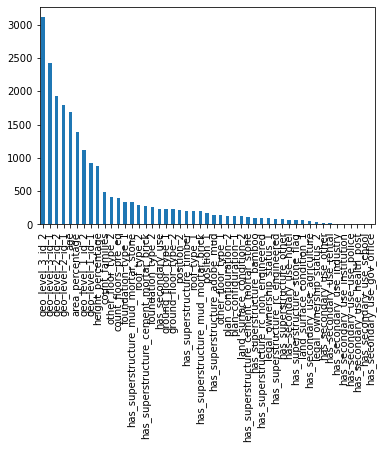

In [81]:
(pd.Series(LGBM.feature_importances_, index=X_te_yj.columns)
   .nlargest(100)
   .plot(kind='bar'))   

## one more try

In [62]:
bag_lgbm = BaggingClassifier(LGBMClassifier(**best_params_lgbm))

In [63]:
bag_lgbm.fit(X_train_te_yj,y_train)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


BaggingClassifier(base_estimator=LGBMClassifier(bagging_fraction=0.7,
                                                feature_fraction=1.0,
                                                feature_fraction_bynode=0.7,
                                                max_bin=1000,
                                                min_child_samples=150,
                                                num_class=3, num_leaves=72,
                                                objective='multiclass',
                                                random_state=17, verbosity=-1))

In [64]:
y_pred_lgbm = bag_lgbm.predict(X_test_te_yj)

f1score_lgbm_bag=f1_score(y_test,y_pred_lgbm,average='micro')
f1score_lgbm_bag

0.7615740296617487

In [244]:
pipeline_lgbmbag= make_pipeline(RFE(LGBM, n_features_to_select=35),
                             bag_lgbm)

In [245]:
pipeline_lgbmbag.fit(X_te_yj,df_trainY['damage_grade'])

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


Pipeline(steps=[('rfe',
                 RFE(estimator=LGBMClassifier(bagging_fraction=0.7,
                                              feature_fraction=1.0,
                                              feature_fraction_bynode=0.7,
                                              max_bin=1000,
                                              min_child_samples=150,
                                              num_class=3, num_leaves=72,
                                              objective='multiclass',
                                              random_state=17, verbosity=-1),
                     n_features_to_select=35)),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=LGBMClassifier(bagging_fraction=0.7,
                                                                 feature_fraction=1.0,
                                                                 feature_fraction_bynode=0.7,
                                                            